# Average Gate Fidelity
Instead of performing process tomography on a system, it is possible to use a series of state tomographies and calculate an average gate fidelity from the measured density matices. To achieve this, the following equation can be used <cite data-cite="Nielsen_2002">(AA2010)</cite>:

$\begin{equation}\overline{F}(\mathcal{E}, U) = \frac{\sum_{jk}\alpha_{jk}tr(UU_j^{\dagger}U^{\dagger}\mathcal{E}(\rho_k))+d^2}{d^2(d+1)}\end{equation},$

where $\mathcal{E}(\rho_k) = \rho_k^\prime$ is the result from a single state tomography experiment with input $k$. This sum can then be evaluated using the input basis $\ket{0}$, $\ket{1}$, $\frac{\ket{0} + \ket{1}}{\sqrt{2}}$ & $\frac{\ket{0} + i\ket{1}}{\sqrt{2}}$ to determine an estimate for gate fidelity.

This notebook demonstates how the included GateFidelity object in Lightworks can be used to automate the process of gathering and analysing data to find the average gate fidelities.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator, qubit
from lightworks.tomography import GateFidelity

As with process tomography, an experiment function needs to be defined which accepts a list of circuits and a list of inputs. In this example, as additional source_indistinguishability argument is included to allow for variation of this value, it defaults to a value of 1.

In [18]:
def experiment(
    circuits: list[lw.Circuit],
    inputs: list[lw.State],
    source_indistinguishability: float = 1.0,
) -> list:
    """
    Experiment function which is required for performing state tomography on a
    system. It takes a list of circuits and generates a corresponding list of
    results for each of them. Only supports one qubit systems currently.
    """
    # Post-select on 1 photon across each pair of qubit modes
    post_select = lw.PostSelection()
    post_select.add((0, 1), 1)
    post_select.add((2, 3), 1)

    # Generate results and return
    results = []
    for circ, in_s in zip(circuits, inputs):
        sampler = emulator.Sampler(
            circ,
            in_s,
            source=emulator.Source(
                indistinguishability=source_indistinguishability
            ),
        )
        results.append(
            sampler.sample_N_outputs(20000, seed=10, post_select=post_select)
        )
    return results

For this tutorial, the 2 qubit CNOT gate is used, which is created and shown below.

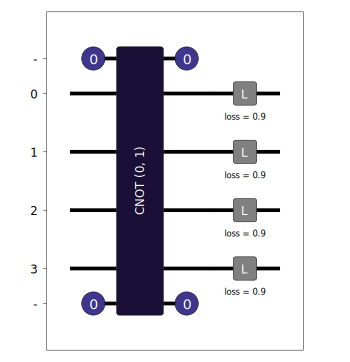

In [19]:
n_qubits = 2

cnot = qubit.CNOT()
for i in range(4):
    cnot.loss(i, 0.9)
cnot.display(display_loss=True)

## Ideal System
To measure the average gate fidelity, a new GateFidelity object is created with the required configuration. Initially, we want to test an ideal system, so the photon indistinguishability is set to 1. The experiment_args value needs to be an iterable such as a list, hence why this is supplied as [1].

In [20]:
gate_f = GateFidelity(n_qubits, cnot, experiment, experiment_args=[1])

The fidelity is then calculated with the process method. Unlike the other tomography approaches, the average gate fidelity requires knowledge of the expected unitary matrix for the gate. In the case of the CNOT gate, this is

\begin{equation} \text{U}_\text{cnot} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix},\end{equation}

which is encoded within the array below.

As expected, the calculated fidelity with an ideal system is 100%.

In [21]:
u_cnot = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
avg_fidelity = gate_f.process(u_cnot)

print(f"Average gate fidelity = {avg_fidelity * 100} %")

Average gate fidelity = 100.32799999999999 %


## Photon Distinguishability

It is then possible to use the built-in noise modelling in Lightworks to simulate the likely effect that this has on the gate fidelity. A key limitation for gate fidelity is the extent to which photons are indistinguishable from each other, with distinguishability reducing overall fidelity.

To examine this effect, we sweep the photon indistinguishability from 80 to 100% and calculate the fidelity at each point. This is then plotted to view the relationship between the two quantities.

.. note:: This cell may take a while to execute (~1 min).

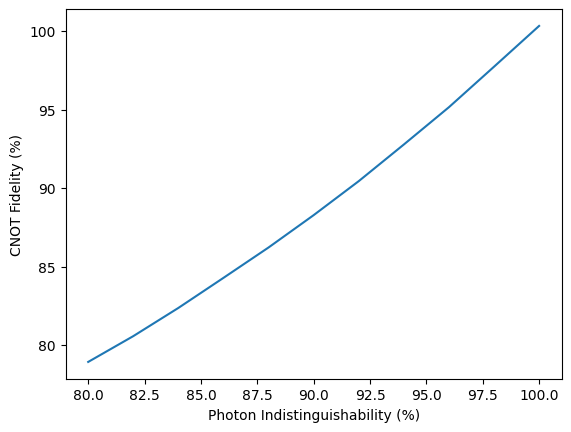

In [22]:
indistinguishability = range(80, 101, 2)

fidelities = []
for ind in indistinguishability:
    # Modify experiment args with new value
    gate_f.experiment_args = [ind / 100]
    # Then re-calculate fidelity
    fidelities.append(gate_f.process(u_cnot) * 100)

plt.plot(indistinguishability, fidelities)
plt.xlabel("Photon Indistinguishability (%)")
plt.ylabel("CNOT Fidelity (%)")
plt.show()